In [6]:
import wandb
from tqdm import tqdm
import torch
import os
import shutil
import matplotlib.pyplot as plt
from devinterp.slt import estimate_learning_coeff, estimate_learning_coeff_with_summary
from devinterp.optim import SGLD
from common.env.procgen_wrappers import *
from common.logger import Logger
from common.storage import Storage
from common.model import NatureModel, ImpalaModel
from common.policy import CategoricalPolicy, CategoricalValueNetwork
from common import set_global_seeds, set_global_log_levels

import os, time, yaml, argparse
import gym
from procgen import ProcgenEnv
import random
import torch
from agents.ppo import PPO as AGENT
import random
import yaml
from devinterp.utils import plot_trace

plt.rcParams["figure.figsize"]=15,12  # note: this cell may need to be re-run after creating a plot to take effect

def plot_trace_and_save(trace, y_axis, name, x_axis='step', title=None, plot_mean=True, plot_std=True, fig_size=(12, 9), true_lc=None):
    num_chains, num_draws = trace.shape
    sgld_step = list(range(num_draws))

    plt.figure(figsize=fig_size)

    if true_lc:
        plt.axhline(y=true_lc, color='r', linestyle='dashed')
    
    # trace
    for i in range(num_chains):
        draws = trace[i]
        plt.plot(sgld_step, draws, linewidth=1, label=f'chain {i}')

    # mean
    if plot_mean:
        mean = np.mean(trace, axis=0)
        plt.plot(sgld_step, mean, color='black', linestyle='--', linewidth=2, label='mean', zorder=3)
    
    # std
    if plot_std:
        std = np.std(trace, axis=0)
        plt.fill_between(sgld_step, mean - std, mean + std, color='gray', alpha=0.3, zorder=2)

    if title is None:
        title = f'{y_axis} values over sampling draws'
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))    
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.tight_layout()
    plt.savefig(name)
    plt.show()
    plt.close()

# def estimate_learning_coeff(
#     model: torch.nn.Module,
#     loader: DataLoader,
#     criterion: Callable,
#     sampling_method: Type[torch.optim.Optimizer] = SGLD,
#     optimizer_kwargs: Optional[Dict[str, Union[float, Literal["adaptive"]]]] = None,
#     num_draws: int = 100,
#     num_chains: int = 10,
#     num_burnin_steps: int = 0,
#     num_steps_bw_draws: int = 1,
#     cores: int = 1,
#     seed: Optional[Union[int, List[int]]] = None,
#     device: torch.device = torch.device("cpu"),
#     verbose: bool = True,
#     callbacks: List[Callable] = [],
# ) -> float:

# og run made with:
# python train.py --exp_name hard-run --env_name maze_aisc --param_name easy --num_levels 0 --distribution_mode easy --num_timesteps 200000000 --num_checkpoints 1000

# Excess defaults from train.py for reference:
#     parser.add_argument('--exp_name',         type=str, default = 'test', help='experiment name')
#     parser.add_argument('--env_name',         type=str, default = 'starpilot', help='environment ID')
#     parser.add_argument('--start_level',      type=int, default = int(0), help='start-level for environment')
#     parser.add_argument('--num_levels',       type=int, default = int(0), help='number of training levels for environment')
#     parser.add_argument('--distribution_mode',type=str, default = 'easy', help='distribution mode for environment')
#     parser.add_argument('--param_name',       type=str, default = 'easy-200', help='hyper-parameter ID')
#     parser.add_argument('--device',           type=str, default = 'gpu', required = False, help='whether to use gpu')
#     parser.add_argument('--gpu_device',       type=int, default = int(0), required = False, help = 'visible device in CUDA')
#     parser.add_argument('--num_timesteps',    type=int, default = int(25000000), help = 'number of training timesteps')
#     parser.add_argument('--seed',             type=int, default = random.randint(0,9999), help='Random generator seed')
#     parser.add_argument('--log_level',        type=int, default = int(40), help='[10,20,30,40]')
#     parser.add_argument('--num_checkpoints',  type=int, default = int(1), help='number of checkpoints to store')


def get_model_number(model_name):
    # model is of format model_<number>:v<version>
    return int(model_name.split('_')[1].split(':')[0])

# Set your specific run ID here
run_id = "jp9tjfzd"
project_name = "procgen"

# Initialize wandb API
api = wandb.Api()

# Fetch the run
run = api.run(f"{project_name}/{run_id}")

torch.manual_seed(1)

####################
## HYPERPARAMETERS #
#################### 
param_name = 'easy'
gpu_device = int(0)
env_name = "maze_aisc"
start_level = 0
num_levels = 0
distribution_mode = "easy"
exp_name = "hard-run"
seed = random.randint(0,9999)
num_checkpoints = 0

print('[LOADING HYPERPARAMETERS...]')
with open('hyperparams/procgen/config.yml', 'r') as f:
    hyperparameters = yaml.safe_load(f)[param_name]
for key, value in hyperparameters.items():
    print(key, ':', value)

############
## DEVICE ##
############
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_device)
device = torch.device('cuda')

#################
## ENVIRONMENT ##
#################
print('INITIALIZAING ENVIRONMENTS...')
n_steps = hyperparameters.get('n_steps', 256)
n_envs = hyperparameters.get('n_envs', 64)
# By default, pytorch utilizes multi-threaded cpu
# Procgen is able to handle thousand of steps on a single core
torch.set_num_threads(1)
env = ProcgenEnv(num_envs=n_envs,
                    env_name=env_name,
                    start_level=start_level,
                    num_levels=num_levels,
                    distribution_mode=distribution_mode, 
                    rand_region = 5) 
normalize_rew = hyperparameters.get('normalize_rew', True)
env = VecExtractDictObs(env, "rgb")
if normalize_rew:
    env = VecNormalize(env, ob=False) # normalizing returns, but not the img frames.
env = TransposeFrame(env)
env = ScaledFloatFrame(env)

############
## LOGGER ##
############
print('INITIALIZAING LOGGER...')
logdir = 'procgen/' + env_name + '/' + exp_name + '/' + 'seed' + '_' + \
            str(seed) + '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join('logs', logdir)
if not (os.path.exists(logdir)):
    os.makedirs(logdir)
logger = Logger(n_envs, logdir)

artifacts = run.logged_artifacts()

artifact = artifacts[8000]
artifact_to_download = api.artifact(f"{project_name}/{artifact.name}", type="model")
artifact_dir = artifact_to_download.download()
# artifact_dir = "artifacts/model_160022528:v0"
model_file = f"{artifact_dir}/{artifact.name[:-3]}.pth"


hidden_state_dim = 0
observation_space = env.observation_space
observation_shape = observation_space.shape
storage = Storage(observation_shape, hidden_state_dim, n_steps, n_envs, device)

loaded_checkpoint = torch.load(model_file)
model = ImpalaModel(in_channels = observation_shape[0])
policy = CategoricalPolicy(model, False, env.action_space.n)
if "state_dict" in loaded_checkpoint:
    policy.load_state_dict(loaded_checkpoint['state_dict'])
elif "model_state_dict" in loaded_checkpoint:
    policy.load_state_dict(loaded_checkpoint['model_state_dict'])
policy.to(device)
agent = AGENT(env, policy, logger, storage, device, num_checkpoints, **hyperparameters)

datapoints = 100
dataloader = agent.generate_data_loader(datapoints)
value_network = CategoricalValueNetwork(model, False, env.action_space.n)
if "state_dict" in loaded_checkpoint:
    value_network.load_state_dict(loaded_checkpoint['state_dict'])
elif "model_state_dict" in loaded_checkpoint:
    value_network.load_state_dict(loaded_checkpoint['model_state_dict'])

# epsilons from 1e-6 to 1e-15
# gammas from 1e6 to 1e15
# epsilons = np.logspace(-6, -15, 10)
# gammas = np.logspace(6, 15, 10)
# num_chains = 8
# num_draws = 2000

epsilons = [1e-7, 1e-8]
gammas = [1e6, 1e7]
num_chains = 1
num_draws = 100

criterion = torch.nn.CrossEntropyLoss()
def estimate_llcs_sweeper(model, epsilons, gammas):
    results = {}
    for epsilon in epsilons:
        for gamma in gammas:
            optim_kwargs = dict(
                lr=epsilon,
                noise_level=1.0,
                elasticity=gamma,
                num_samples=datapoints,
                temperature="adaptive",
            )
            pair = (epsilon, gamma)
            results[pair] = estimate_learning_coeff_with_summary(
                model=model,
                loader=dataloader,
                criterion=criterion,
                sampling_method=SGLD,
                optimizer_kwargs=optim_kwargs,
                num_chains=num_chains,
                num_draws=num_draws,
                device=device,
                online=True,
            )
    return results

def plot_single_graph(result, title=''):
    llc_color = 'teal'
    fig, axs = plt.subplots(1, 1)
    # plot loss traces
    loss_traces = result['loss/trace']
    for trace in loss_traces:
        init_loss = trace[0]
        zeroed_trace = trace - init_loss
        sgld_steps = list(range(len(trace)))
        axs.plot(sgld_steps, zeroed_trace)

    # plot llcs
    means = result['llc/means']
    stds = result['llc/stds']
    sgld_steps = list(range(len(means)))
    axs2 = axs.twinx() 
    axs2.plot(sgld_steps, means, color=llc_color, linestyle='--', linewidth=2, label=f'llc', zorder=3)
    axs2.fill_between(sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2)

    # center zero, assume zero is in the range of both y axes already
    y1_min, y1_max = axs.get_ylim()
    y2_min, y2_max = axs2.get_ylim()
    y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
    y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
    percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
    y1_amt_to_add = (y1_max - y1_min) * percent_to_add
    y2_amt_to_add = (y2_max - y2_min) * percent_to_add
    if y1_zero_ratio < y2_zero_ratio:
        # add to bottom of y1 and top of y2
        y1_min -= y1_amt_to_add
        y2_max += y2_amt_to_add
    elif y2_zero_ratio < y1_zero_ratio:
        # add to bottom of y2 and top of y1
        y2_min -= y2_amt_to_add
        y1_max += y1_amt_to_add
    axs.set_ylim(y1_min, y1_max)
    axs2.set_ylim(y2_min, y2_max)
    axs.set_xlabel('SGLD time step')
    axs.set_ylabel('loss')
    axs2.set_ylabel('llc', color=llc_color)
    axs2.tick_params(axis='y', labelcolor=llc_color)
    axs.axhline(color='black', linestyle=':')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_sweep_single_model(results, epsilons, gammas, **kwargs):
    llc_color = 'teal'
    fig, axs = plt.subplots(len(epsilons), len(gammas))

    for i, epsilon in enumerate(epsilons):
        for j, gamma in enumerate(gammas):
            result = results[(epsilon, gamma)]
            # plot loss traces
            loss_traces = result['loss/trace']
            for trace in loss_traces:
                init_loss = trace[0]
                zeroed_trace = trace - init_loss
                sgld_steps = list(range(len(trace)))
                axs[i, j].plot(sgld_steps, zeroed_trace)

            # plot llcs
            means = result['llc/means']
            stds = result['llc/stds']
            sgld_steps = list(range(len(means)))
            axs2 = axs[i, j].twinx() 
            axs2.plot(sgld_steps, means, color=llc_color, linestyle='--', linewidth=2, label=f'llc', zorder=3)
            axs2.fill_between(sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2)

            # center zero, assume zero is in the range of both y axes already
            y1_min, y1_max = axs[i, j].get_ylim()
            y2_min, y2_max = axs2.get_ylim()
            y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
            y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
            percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
            y1_amt_to_add = (y1_max - y1_min) * percent_to_add
            y2_amt_to_add = (y2_max - y2_min) * percent_to_add
            if y1_zero_ratio < y2_zero_ratio:
                # add to bottom of y1 and top of y2
                y1_min -= y1_amt_to_add
                y2_max += y2_amt_to_add
            elif y2_zero_ratio < y1_zero_ratio:
                # add to bottom of y2 and top of y1
                y2_min -= y2_amt_to_add
                y1_max += y1_amt_to_add
            axs[i, j].set_ylim(y1_min, y1_max)
            axs2.set_ylim(y2_min, y2_max)
            
            axs[i, j].set_title(f"$\epsilon$ = {epsilon} : $\gamma$ = {gamma}")
            # only show x axis label on last row
            if i == len(epsilons) - 1:
                axs[i, j].set_xlabel('SGLD time step')
            axs[i, j].set_ylabel('loss')
            axs2.set_ylabel('llc', color=llc_color)
            axs2.tick_params(axis='y', labelcolor=llc_color)
    if kwargs['title']:
        fig.suptitle(kwargs['title'], fontsize=16)
    plt.tight_layout()
    plt.show()

results = estimate_llcs_sweeper(value_network, epsilons, gammas)

[LOADING HYPERPARAMETERS...]
algo : ppo
n_envs : 64
n_steps : 256
epoch : 3
mini_batch_per_epoch : 8
mini_batch_size : 2048
gamma : 0.999
lmbda : 0.95
learning_rate : 0.0005
grad_clip_norm : 0.5
eps_clip : 0.2
value_coef : 0.5
entropy_coef : 0.01
normalize_adv : True
normalize_rew : True
use_gae : True
architecture : impala
recurrent : False
INITIALIZAING ENVIRONMENTS...
INITIALIZAING LOGGER...


wandb:   1 of 1 files downloaded.  
Chain 0: 100%|██████████| 100/100 [00:01<00:00, 95.88it/s]


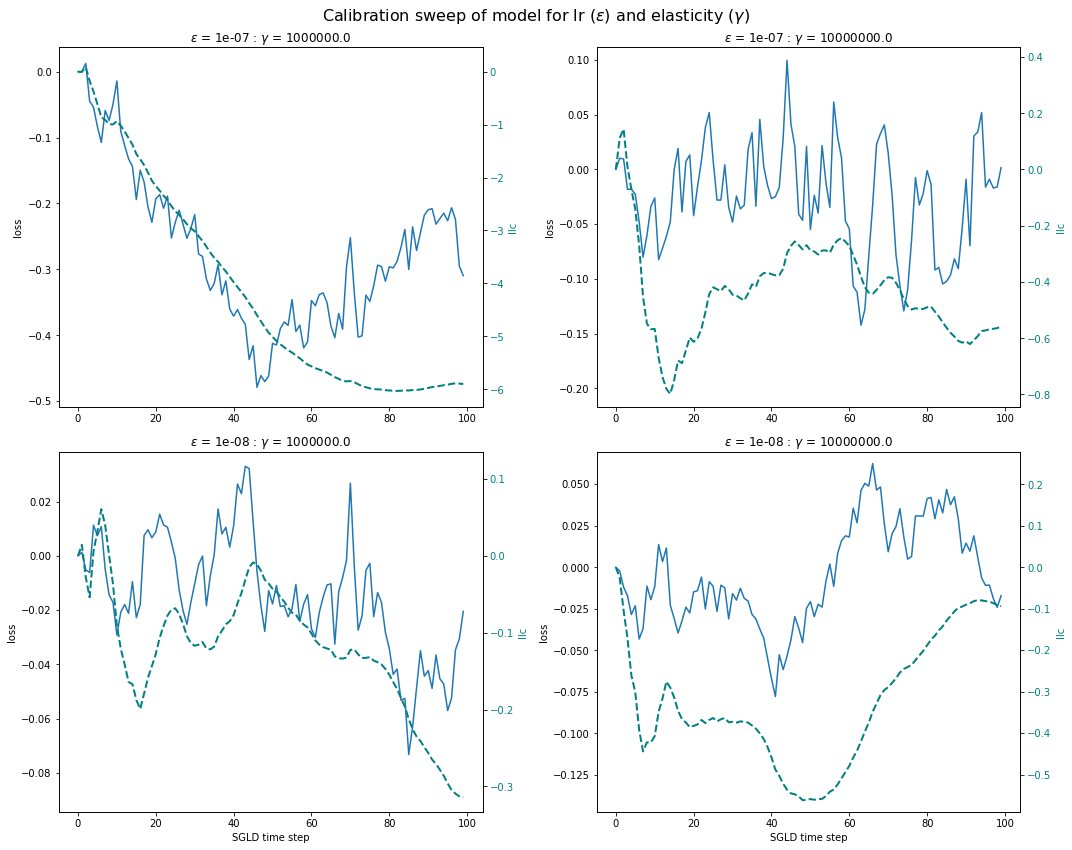

In [7]:
plot_sweep_single_model(results, epsilons, gammas, title='Calibration sweep of model for lr ($\epsilon$) and elasticity ($\gamma$)')